In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import re
import datetime
import pylab as pl
pl.style.use('fivethirtyeight')
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
import statsmodels.api as sma

In [4]:
census = pd.read_csv('PST01.csv')
census = census.rename(columns={'PST045202D': 'Population'})

In [5]:
census.columns

Index([u'Areaname', u'STCOU', u'Population'], dtype='object')

In [6]:
carbon = pd.read_csv('carbon.csv')

In [7]:
carbon.columns

Index([u'State', u'County', u'FIPS', u'Total', u'Commercial', u'Industrial',
       u'Residential', u'Electricity Prod', u'Onroad', u'Cement', u'Aircraft',
       u'Airborne', u'Nonroad'],
      dtype='object')

In [8]:
area = pd.read_csv('land.csv')

In [9]:
area.columns

Index([u'Areaname', u'STCOU', u'area'], dtype='object')

In [12]:
merged = pd.merge(census, area, on='STCOU')

In [13]:
merged = pd.merge(merged, carbon, left_on='STCOU', right_on='FIPS')

In [16]:
merged.columns

Index([u'Areaname_x', u'STCOU', u'Population', u'Areaname_y', u'area',
       u'State', u'County', u'FIPS', u'Total', u'Commercial', u'Industrial',
       u'Residential', u'Electricity Prod', u'Onroad', u'Cement', u'Aircraft',
       u'Airborne', u'Nonroad'],
      dtype='object')

In [26]:
# Filter out areas of 0
merged = merged[merged.area > 0]

In [28]:
# Total is the amount of CO2 emissions in millions of tons
# area is the number of square miles
# CO2PerSquareMile is millions of tons per square mile
merged['CO2PerSquareMile'] = merged['Total']/merged['area']

In [37]:
# CO2PerCapita is Millions of tons per capita
merged['CO2PerCapita'] = merged['Total']/merged['Population']

In [381]:
# ResCO2PerCapita is Millions of tons per capita
merged['ResCO2PerCapita'] = (merged['Total'] - merged['Onroad'])/merged['Population']

In [382]:
merged['ResCO2PerCapita'].describe()

count    3.137000e+03
mean     9.081878e-06
std      3.671871e-05
min      1.800141e-07
25%      1.242196e-06
50%      1.971957e-06
75%      3.867465e-06
max      7.984987e-04
Name: ResCO2PerCapita, dtype: float64

In [45]:
# PopulationDensity in people per square mile
merged['PopulationDensity'] = merged['Population']/merged['area']

In [48]:
def basicPlots(df, plots):
    for x,y,title,xl,yl in plots:
        ax = df.plot(x, y, kind='scatter', logy=True, logx=True, figsize=(10,10))
        ax.set_title(title)
        ax.set_xlabel(xl)
        ax.set_ylabel(yl)

In [ ]:
basicPlots(merged, [
        ('Population', 'Total', 'CO2 Emissions vs. Population by County', 'Population', 'Millions of Tons of CO2'),
        ('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'Population', 'Millions of Tons of CO2 per Square Mile'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population by County', 'Population', 'Millions of Tons of CO2 per Capita'),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density by County', 'Population per Square Mile', 'Millions of Tons of CO2 per Capita'),
        ('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'Population per Square Mile', 'Millions of Tons of CO2 per Square Mile'),
    ])

In [ ]:
basicPlots(merged[merged.Population > 100000], [
        ('Population', 'Total', 'CO2 Emissions vs. Population by County', 'Population', 'Millions of Tons of CO2'),
        ('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'Population', 'Millions of Tons of CO2 per Square Mile'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population by County', 'Population', 'Millions of Tons of CO2 per Capita'),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density by County', 'Population per Square Mile', 'Millions of Tons of CO2 per Capita'),
        ('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'Population per Square Mile', 'Millions of Tons of CO2 per Square Mile'),
    ])

In [465]:
def runRegressions(df, plots):
    mods = []
    for x,y,title,xl,yl,ax,c in plots:
        #figure, ax = pl.subplots(figsize=(10,10))
        
        d = {
            'x': np.log2(df[x]),
            'y': np.log2(df[y]),
            'x2': np.log2(df[x])**2
        }
        
        logPop = np.log(df[c])
        min = np.min(logPop)
        max = np.max(logPop)
        
        a = -256./(min - max)
        b = 0 + -1 * min * a
        colors = logPop*a + b
        
        #a = -400./(df['Population'].min() - df['Population'].max())
        #b = 15 + -1 * df['Population'].min() * a
        #sizes = df['Population']*a + b
        
        a = 400./(max-min)
        b = 20 - min * a
        sizes = logPop*a + b
        #print sizes
        #print colors
        #sizes = -1*min + logPop*

        
        ax.scatter(d['x'], d['y'], s=sizes, cmap=pl.cm.jet, c=colors)

        mod = smf.ols(formula='y ~ x', data = d).fit()
        mods.append(mod)
        print title
        print mod.summary()
        abline_plot(model_results=mod, ax=ax, color='red', label='Regression')

        
        #mod = smf.ols(formula='y ~ x + x2', data = d).fit()
        #print mod.summary()
        #xlim = ax.get_xlim()
        #x = np.linspace(xlim[0], xlim[1],100)
        #y = mod.params[0] + x*mod.params[1] + (x**2)*mod.params[2]
        #ax.plot(x, y, label='Polynomial')
        
        #ax = df.plot(x, y, kind='scatter', logy=True, logx=True, figsize=(10,10))
        
        
        
        ax.set_title(title)
        ax.set_xlabel(xl)
        ax.set_ylabel(yl)
        
        #ax.plot(ax.get_xlim(), ax.get_ylim(), '--', label='X=Y')
        
        ax.legend(loc='upper left')
    return mods

In [502]:
def commonRegressions(df, axes):
    runRegressions(df, [
        ('Population', 'Total', 'CO2 Emissions vs. Population', 'log(Population)', 'log(Millions of Tons of CO2)', axes[0][0], 'area'),
        #('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Square Mile)'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population', 'log(Population)', 'log(Millions of Tons of CO2 per Capita)', axes[0][1], 'area'),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Capita)', axes[1][1], 'Population'),
        ('area', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Area', 'log(Square Miles)', 'log(Millions of Tons of CO2 per Capita)', axes[1][0], 'Population'),
        #('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Square Mile)'),
    ])

CO2 Emissions vs. Population
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     6528.
Date:                Sun, 15 Nov 2015   Prob (F-statistic):               0.00
Time:                        19:40:15   Log-Likelihood:                -5151.6
No. Observations:                3137   AIC:                         1.031e+04
Df Residuals:                    3135   BIC:                         1.032e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -15.7450  

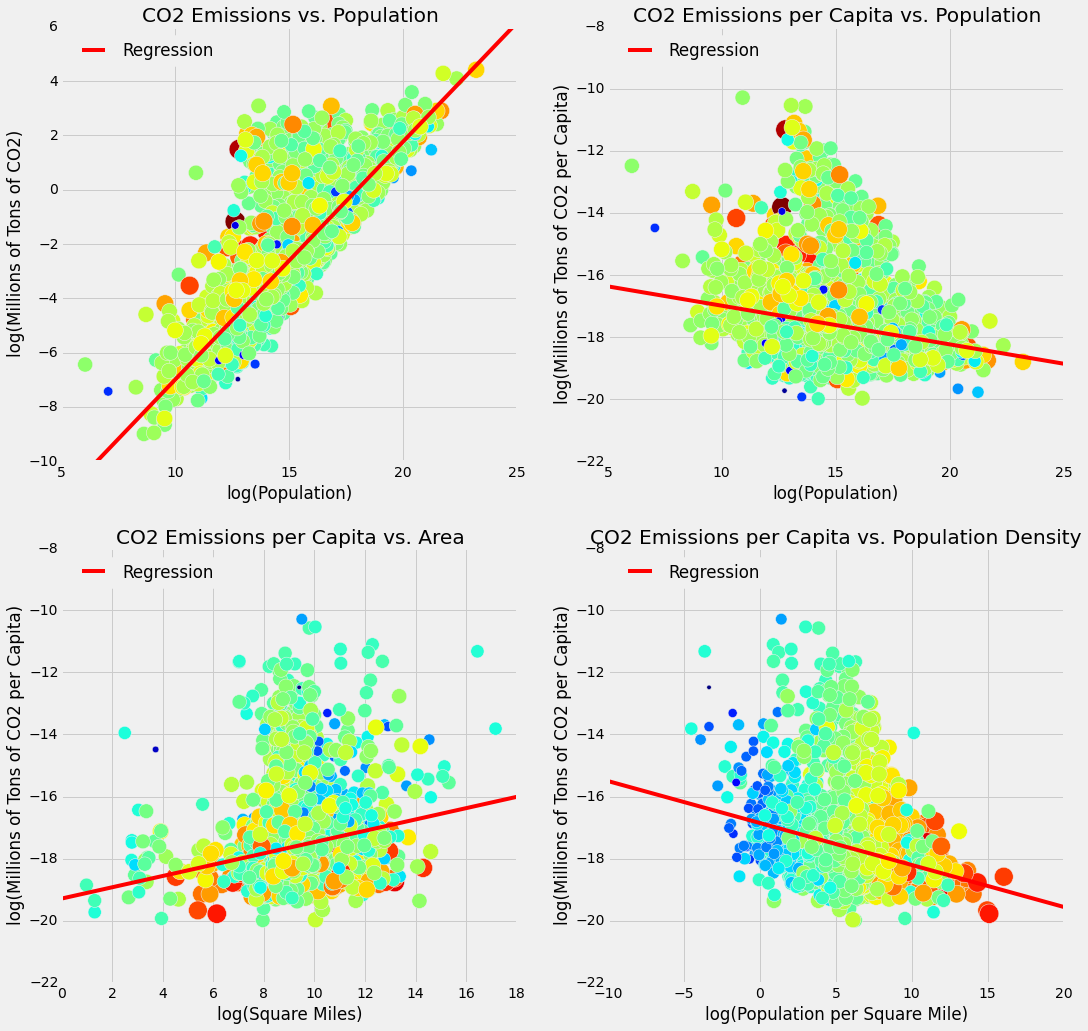

In [503]:
fig, (axes) = plt.subplots(figsize=(16,16), nrows=2, ncols=2)
commonRegressions(merged, axes)

CO2 Emissions per Capita vs. Area
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.08502
Date:                Sun, 15 Nov 2015   Prob (F-statistic):              0.771
Time:                        19:30:40   Log-Likelihood:                -148.20
No. Observations:                 132   AIC:                             300.4
Df Residuals:                     130   BIC:                             306.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -18.2

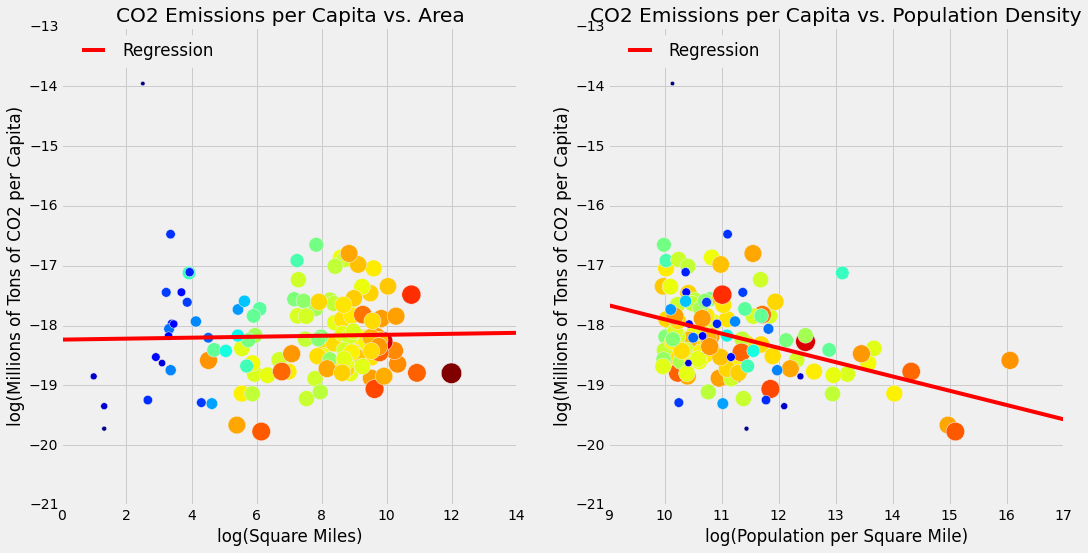

In [494]:
filtered = merged[merged.PopulationDensity>1000]
fig, (axes) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
commonRegressions(filtered, axes)

CO2 Emissions vs. Population by County
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     585.2
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           1.04e-87
Time:                        19:01:45   Log-Likelihood:                -696.36
No. Observations:                 533   AIC:                             1397.
Df Residuals:                     531   BIC:                             1405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    

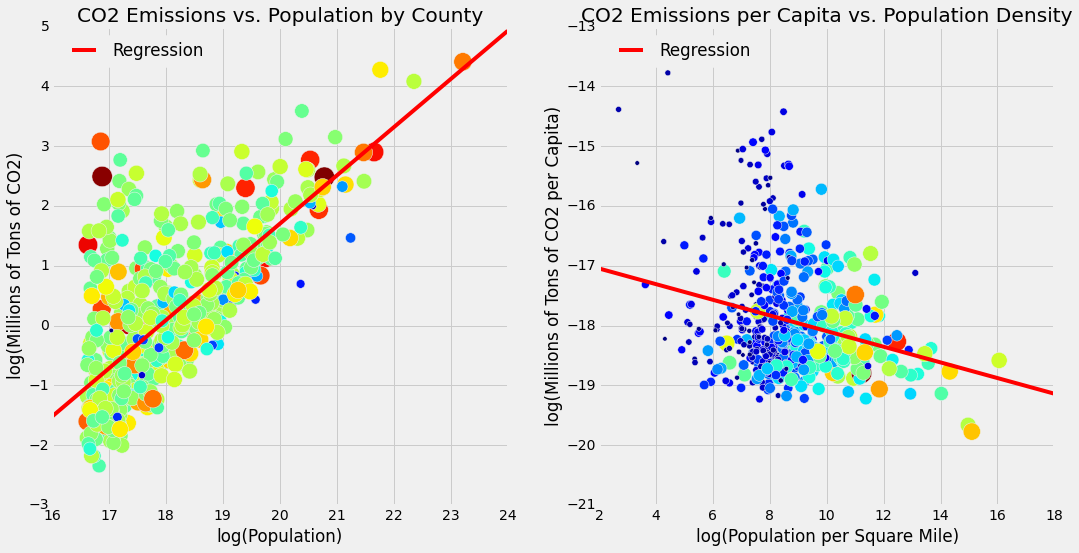

In [469]:
filtered = merged[merged.Population>100000]
fig, (axes) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
commonRegressions(filtered, axes)
#filtered.sort('Population')

#MSA STUFF

In [87]:
msa = pd.read_csv('msa.csv')

In [88]:
msa.columns

Index([u'CBSA Code', u'Metro Division Code', u'CSA Code', u'CBSA Title',
       u'Metropolitan/Micropolitan Statistical Area',
       u'Metropolitan Division Title', u'CSA Title',
       u'County/County Equivalent', u'State Name', u'FIPS State Code',
       u'FIPS County Code', u'Central/Outlying County'],
      dtype='object')

In [89]:
msa = msa.rename(columns={'CBSA Code': 'MSA', 'Central/Outlying County': 'outlying'})

In [113]:
msa['FIPS'] = np.core.defchararray.add(np.array([i.zfill(2) for i in msa['FIPS State Code'].astype(int).astype('str')]), np.array([i.zfill(3) for i in msa['FIPS County Code'].astype(int).astype('str')])).astype(int)

In [116]:
len(msa)

1882

In [470]:
msa_merge = pd.merge(msa, merged, on='FIPS')

In [471]:
len(msa_merge)

1807

In [518]:
grouped = msa_merge.groupby('MSA')

In [519]:
df = pd.DataFrame({
    'Population': grouped.sum()['Population'],
    'Total': grouped.sum()['Total'],
    'area': grouped.sum()['area']
})

df['PopulationDensity'] = grouped.sum()['Population']/grouped.sum()['area']
df['CO2PerCapita'] = grouped.sum()['Total']/grouped.sum()['Population']

In [520]:
df.describe()

,Population,Total,area,PopulationDensity,CO2PerCapita
count,917.000000,917.000000,917.000000,917.000000,917.000000
mean,293309.808070,1.494340,1825.255387,144.297999,0.000008
std,1014496.599869,3.733139,2414.565782,218.562670,0.000018
min,12415.000000,0.032576,103.780000,1.670828,0.000001
25%,38813.000000,0.163245,605.640000,43.632923,0.000003
50%,72000.000000,0.334656,986.510000,83.154634,0.000004
75%,166071.000000,1.154359,2037.160000,148.109148,0.000006
max,19232075.000000,47.924484,27259.870000,2605.004876,0.000259


CO2 Emissions vs. Population
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1863.
Date:                Sun, 15 Nov 2015   Prob (F-statistic):          7.64e-223
Time:                        19:53:39   Log-Likelihood:                -1417.5
No. Observations:                 917   AIC:                             2839.
Df Residuals:                     915   BIC:                             2849.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -16.3591  

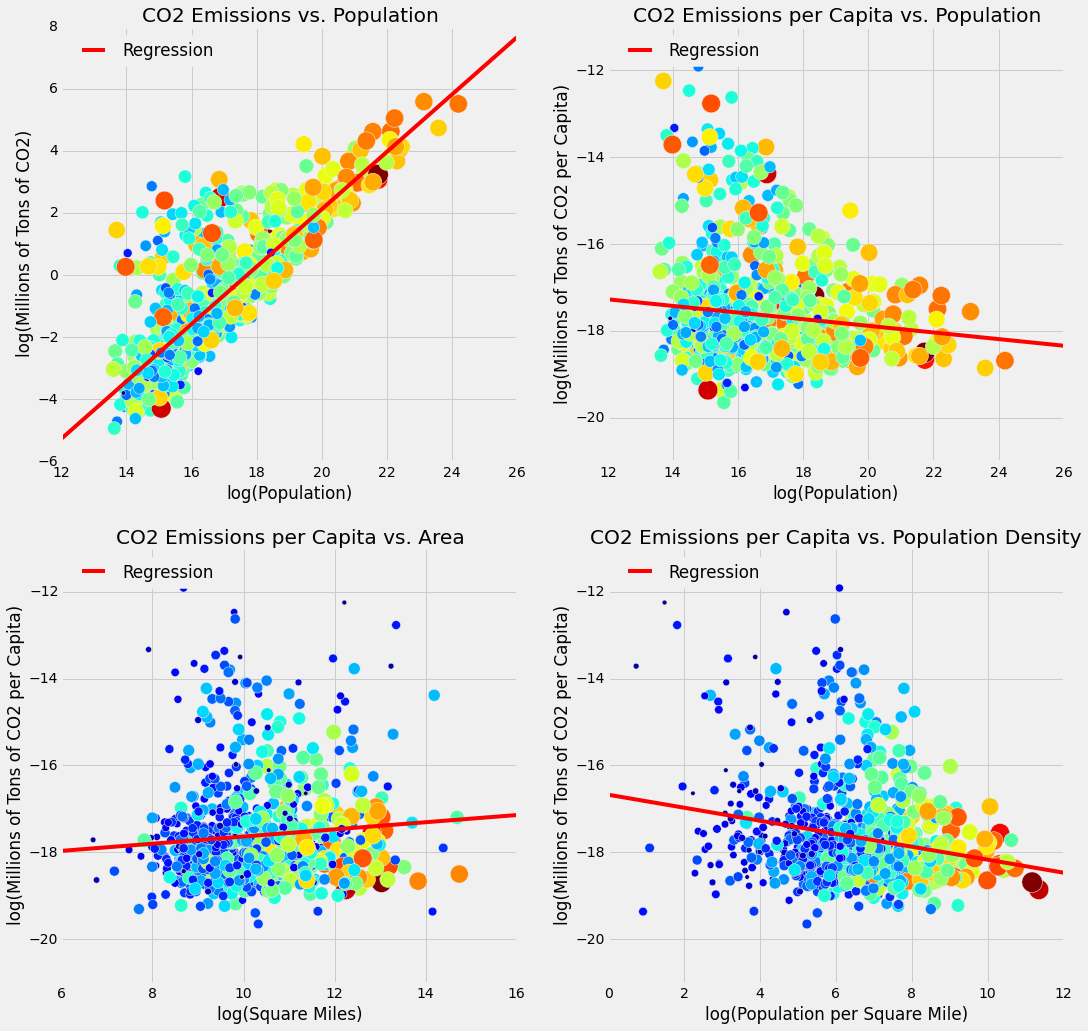

In [505]:
fig, ((axes)) = plt.subplots(figsize=(16,16), nrows=2, ncols=2)
commonRegressions(df, axes)

CO2 Emissions vs. Population
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     1029.
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           1.78e-86
Time:                        20:03:54   Log-Likelihood:                -289.90
No. Observations:                 230   AIC:                             583.8
Df Residuals:                     228   BIC:                             590.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -17.8161  

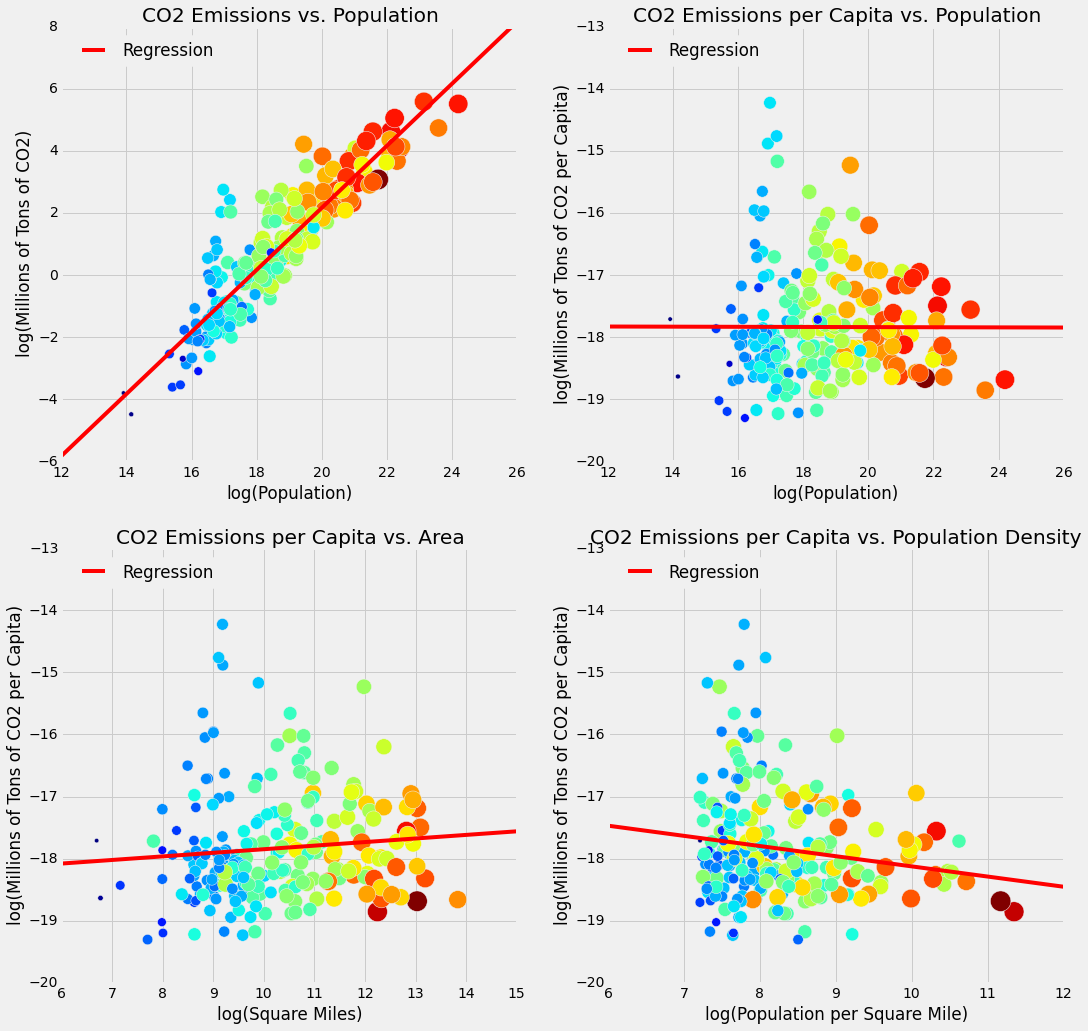

In [521]:
filtered = df[df.PopulationDensity>148]
fig, ((axes)) = plt.subplots(figsize=(16,16), nrows=2, ncols=2)
commonRegressions(filtered, axes)

In [529]:
merged.PopulationDensity.describe()

count     3137.000000
mean       246.803324
std       1692.453933
min          0.043674
25%         16.956660
50%         42.955963
75%        106.266794
max      68259.625436
Name: PopulationDensity, dtype: float64

CO2 Emissions per Capita vs. Area (County)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2665
Date:                Sun, 15 Nov 2015   Prob (F-statistic):              0.606
Time:                        20:18:03   Log-Likelihood:                -1155.2
No. Observations:                 787   AIC:                             2314.
Df Residuals:                     785   BIC:                             2324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept

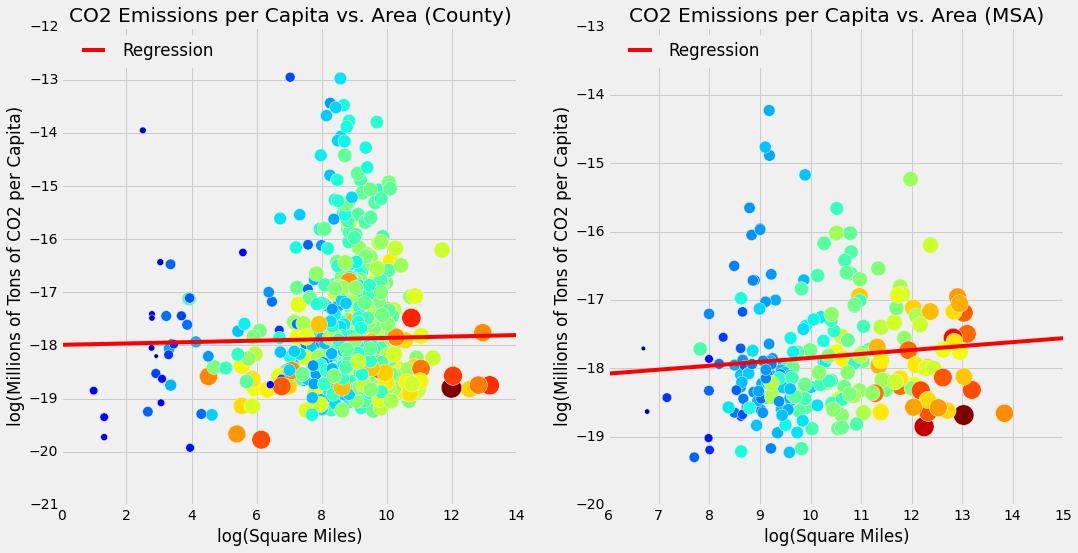

In [531]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

filtered = merged[merged.PopulationDensity>106]
runRegressions(filtered, [
        ('area', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Area (County)', 'log(Square Miles)', 'log(Millions of Tons of CO2 per Capita)', ax1, 'Population'),
     ])

filtered = df[df.PopulationDensity>148]
runRegressions(filtered, [
        ('area', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Area (MSA)', 'log(Square Miles)', 'log(Millions of Tons of CO2 per Capita)', ax2, 'Population'),
     ])



In [ ]:
filtered = df[df.PopulationDensity>83]
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
runRegressions(filtered, [
        #('Population', 'Total', 'CO2 Emissions vs. Population by MSA', 'log(Population)', 'log(Millions of Tons of CO2)'),
        #('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Square Mile)'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population', 'log(Population)', 'log(Millions of Tons of CO2 per Capita)', ax1),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Capita)', ax2),
        #('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Square Mile)'),
    ])

In [302]:
woOutlying = msa_merge[msa_merge.outlying=='Central']
grouped = woOutlying.groupby('MSA')

df = pd.DataFrame({
    'Population': grouped.sum()['Population'],
    'Total': grouped.sum()['Total']
})

df['PopulationDensity'] = grouped.sum()['Population']/grouped.sum()['area']
df['CO2PerCapita'] = grouped.sum()['Total']/grouped.sum()['Population']



CO2 Emissions per Capita vs. Population by County
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     19.93
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           9.03e-06
Time:                        11:48:45   Log-Likelihood:                -298.74
No. Observations:                 917   AIC:                             601.5
Df Residuals:                     915   BIC:                             611.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
In

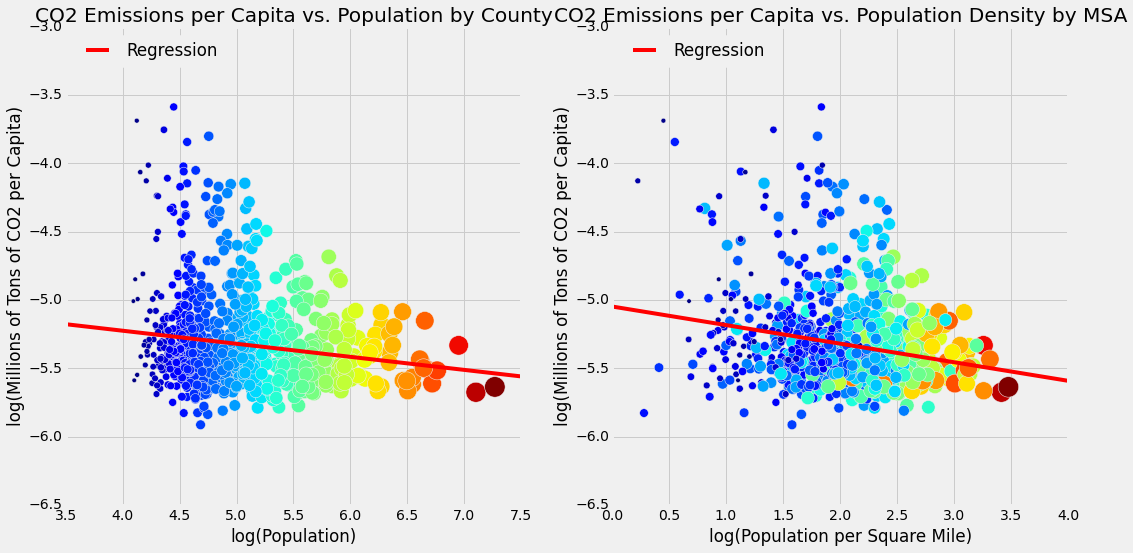

In [303]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
runRegressions(df, [
        #('Population', 'Total', 'CO2 Emissions vs. Population by MSA', 'log(Population)', 'log(Millions of Tons of CO2)'),
        #('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Square Mile)'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Capita)', ax1),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density by MSA', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Capita)', ax2),
        #('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Square Mile)'),
    ])

CO2 Emissions per Capita vs. Population
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     9.814
Date:                Sun, 15 Nov 2015   Prob (F-statistic):            0.00188
Time:                        11:49:49   Log-Likelihood:                -38.849
No. Observations:                 345   AIC:                             81.70
Df Residuals:                     343   BIC:                             89.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   

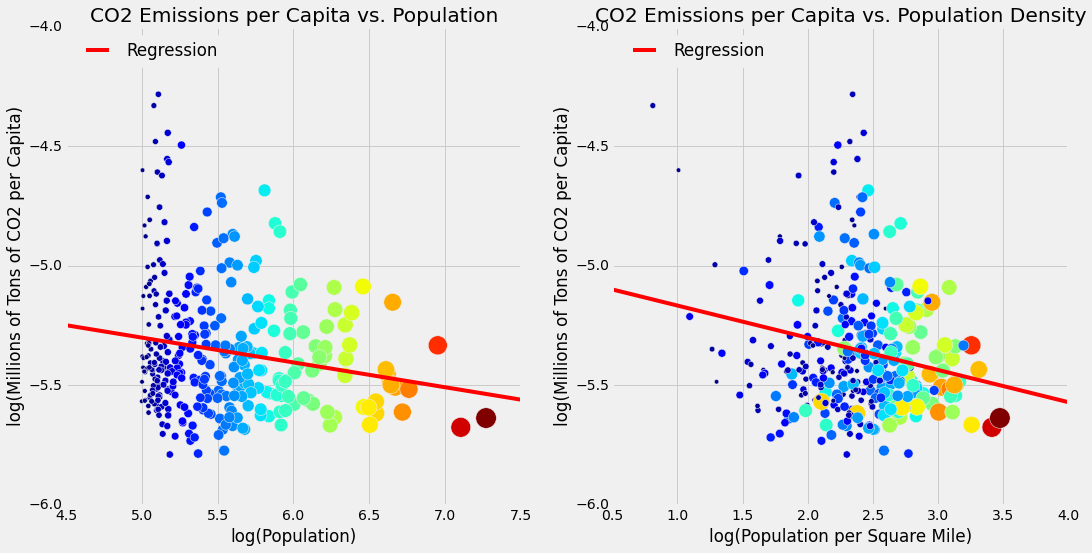

In [304]:
filtered = df[df.Population>100000]
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
runRegressions(filtered, [
        #('Population', 'Total', 'CO2 Emissions vs. Population by MSA', 'log(Population)', 'log(Millions of Tons of CO2)'),
        #('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Square Mile)'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population', 'log(Population)', 'log(Millions of Tons of CO2 per Capita)', ax1),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Capita)', ax2),
        #('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Square Mile)'),
    ])

In [ ]:
#woOutlying = msa_merge[msa_merge.outlying=='Central']
#grouped = woOutlying.groupby('MSA')

#df = pd.DataFrame({
#    'Population': grouped.sum()['Population'],
#    'Total': grouped.sum()['Total']
#})

#df['PopulationDensity'] = grouped.sum()['Population']/grouped.sum()['area']
#df['CO2PerCapita'] = grouped.sum()['Total']/grouped.sum()['Population']

In [344]:
#densest = msa_merge[msa_merge.PopulationDensity > 80]
#grouped = densest.groupby('MSA')
pop = []
total = []
area = []
grouped = msa_merge.groupby('MSA')

for name, group in grouped:
    # Get only counties with population >= mean for the MSA
    try:
        f = group[group.PopulationDensity >= group.PopulationDensity.mean()]# + 3*group.Population.std()]
        if len(f) < 1:
            raise Exception
    except:
        f = group[group.PopulationDensity >= group.PopulationDensity.mean()]
    pop.append(f.Population.sum())
    total.append(f.Total.sum())
    area.append(f.area.sum())

#grouped.get_group(47900)[grouped.get_group(47900).Population >= grouped.get_group(47900).Population.mean()]

df = pd.DataFrame({
    'Population': pop,
    'Total': total,
    'area': area
})

df['PopulationDensity'] = df['Population']/df['area']
df['CO2PerCapita'] = df['Total']/df['Population']

CO2 Emissions per Capita vs. Population by County
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     33.88
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           8.11e-09
Time:                        12:10:27   Log-Likelihood:                -293.58
No. Observations:                 917   AIC:                             591.2
Df Residuals:                     915   BIC:                             600.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
In

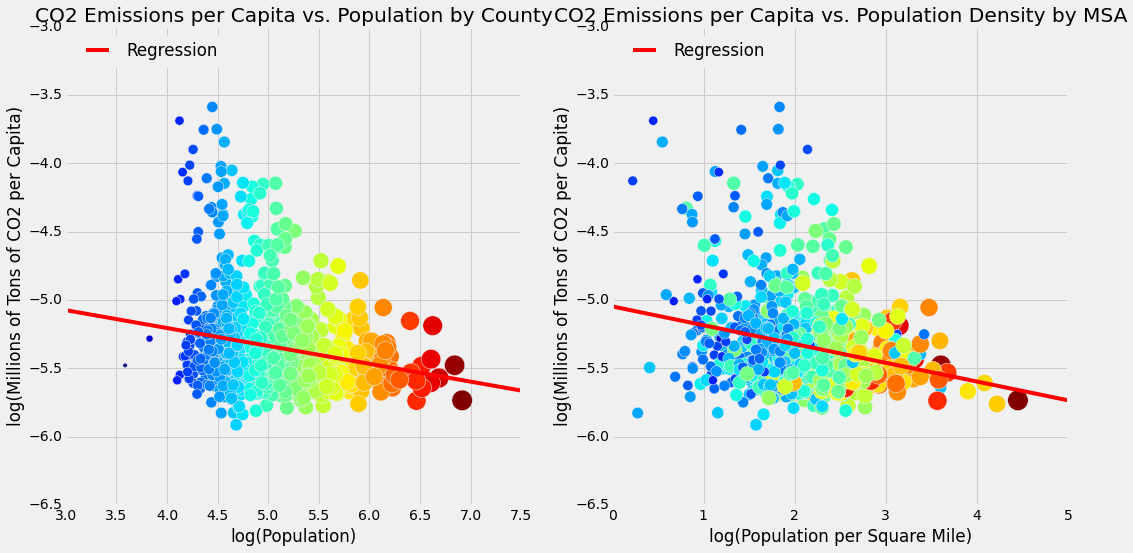

In [345]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
runRegressions(df, [
        #('Population', 'Total', 'CO2 Emissions vs. Population by MSA', 'log(Population)', 'log(Millions of Tons of CO2)'),
        #('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Square Mile)'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Capita)', ax1),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density by MSA', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Capita)', ax2),
        #('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Square Mile)'),
    ])

CO2 Emissions per Capita vs. Population
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     16.68
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           5.61e-05
Time:                        12:10:58   Log-Likelihood:                -26.512
No. Observations:                 320   AIC:                             57.02
Df Residuals:                     318   BIC:                             64.56
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   

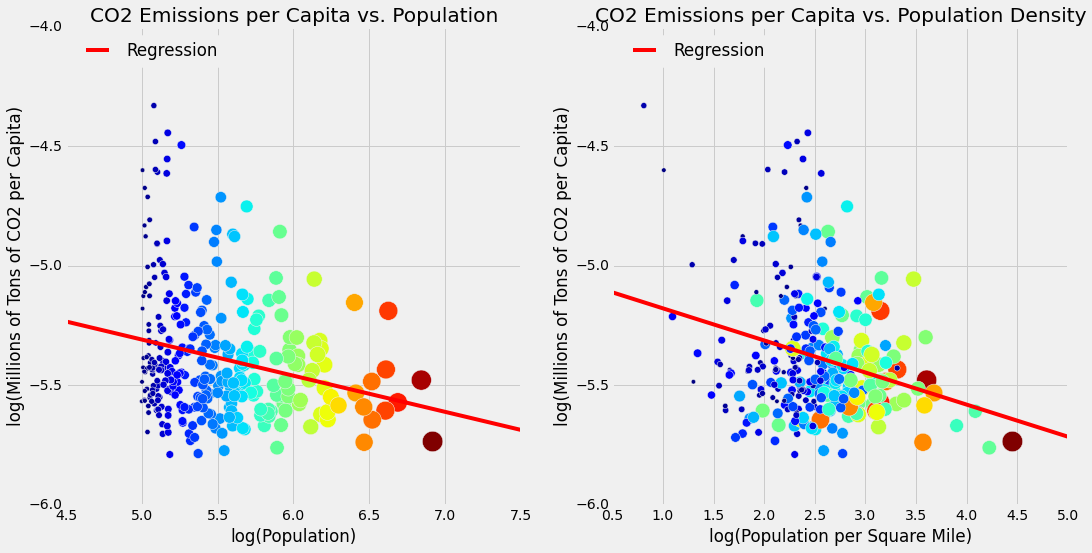

In [347]:
filtered = df[df.Population>100000]
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
runRegressions(filtered, [
        #('Population', 'Total', 'CO2 Emissions vs. Population by MSA', 'log(Population)', 'log(Millions of Tons of CO2)'),
        #('Population', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population by County', 'log(Population)', 'log(Millions of Tons of CO2 per Square Mile)'),
        ('Population', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population', 'log(Population)', 'log(Millions of Tons of CO2 per Capita)', ax1),
        ('PopulationDensity', 'CO2PerCapita', 'CO2 Emissions per Capita vs. Population Density', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Capita)', ax2),
        #('PopulationDensity', 'CO2PerSquareMile', 'CO2 Emissions per Square Mile vs. Population Density by County', 'log(Population per Square Mile)', 'log(Millions of Tons of CO2 per Square Mile)'),
    ])

In [352]:
merged.sort('CO2PerCapita')

,Areaname_x,STCOU,Population,Areaname_y,area,State,County,FIPS,Total,Commercial,...,Residential,Electricity Prod,Onroad,Cement,Aircraft,Airborne,Nonroad,CO2PerSquareMile,CO2PerCapita,PopulationDensity
407,"Chattahoochee, GA",13053,19189,"Chattahoochee, GA",248.77,GA,Chattahoochee,13053,0.018480,0.000557,...,0.001963,0.000000,0.014166,0.000000,0.000000,0.000000,0.001708,0.000074,9.630607e-07,77.135507
2567,"Coryell, TX",48099,73341,"Coryell, TX",1051.76,TX,Coryell,48099,0.071437,0.003575,...,0.005090,0.000000,0.054167,0.000000,0.000451,0.001133,0.004557,0.000068,9.740413e-07,69.731688
2937,"Poquoson, VA",51735,11625,"Poquoson, VA",15.52,VA,Poquoson,51735,0.011658,0.000540,...,0.003321,0.000000,0.005906,0.000000,0.000000,0.000000,0.001628,0.000751,1.002844e-06,749.033505
1846,"Kings, NY",36047,2477380,"Kings, NY",70.61,NY,Kings,36047,2.762536,0.304717,...,1.263711,0.365362,0.591724,0.000000,0.000000,0.000000,0.140547,0.039124,1.115104e-06,35085.398669
2928,"Lexington, VA",51678,6877,"Lexington, VA",2.49,VA,Lexington,51678,0.007931,0.001664,...,0.001733,0.000000,0.003030,0.000000,0.000000,0.000000,0.000222,0.003185,1.153258e-06,2761.847390
1825,"Bronx, NY",36005,1348285,"Bronx, NY",42.03,NY,Bronx,36005,1.620503,0.212080,...,0.627676,0.111605,0.566572,0.000000,0.000000,0.000000,0.057057,0.038556,1.201899e-06,32079.110159
2679,"Maverick, TX",48323,48315,"Maverick, TX",1280.08,TX,Maverick,48323,0.058876,0.002861,...,0.000411,0.000000,0.048441,0.000000,0.000161,0.000405,0.002402,0.000046,1.218596e-06,37.743735
1020,"Estill, KY",21065,15234,"Estill, KY",253.93,KY,Estill,21065,0.019129,0.001067,...,0.004056,0.000000,0.010724,0.000000,0.000000,0.000000,0.001461,0.000075,1.255684e-06,59.992911
2731,"Starr, TX",48427,55862,"Starr, TX",1223.02,TX,Starr,48427,0.081179,0.002616,...,0.001048,0.000000,0.052789,0.000000,0.000181,0.000454,0.004032,0.000066,1.453205e-06,45.675459
2950,"Asotin, WA",53003,20511,"Asotin, WA",635.34,WA,Asotin,53003,0.029986,0.002258,...,0.008299,0.000000,0.015332,0.000000,0.000000,0.000000,0.002831,0.000047,1.461952e-06,32.283502


In [357]:
grouped = msa_merge.groupby('MSA')
df = pd.DataFrame({
    #'MSA': grouped.groups.keys(),
    'MSA': [g.iloc[0]['CBSA Title'] for _,g in grouped],
    'Population': grouped.sum()['Population'],
    'Total': grouped.sum()['Total']
})

df['PopulationDensity'] = grouped.sum()['Population']/grouped.sum()['area']
df['CO2PerCapita'] = grouped.sum()['Total']/grouped.sum()['Population']

In [361]:
df[df.Population > 500000].sort('CO2PerCapita')

,MSA,Population,Total,PopulationDensity,CO2PerCapita
MSA,,,,,
31080,"Los Angeles-Long Beach-Anaheim, CA",12634977,26.645275,2605.004876,0.000002
23420,"Fresno, CA",828245,1.785504,138.903657,0.000002
32580,"McAllen-Edinburg-Mission, TX",607449,1.438398,386.971811,0.000002
35620,"New York-Newark-Jersey City, NY-NJ-PA",19232075,45.614558,2304.953978,0.000002
38060,"Phoenix-Mesa-Scottsdale, AZ",3496957,8.441516,239.965813,0.000002
21340,"El Paso, TX",692083,1.671084,123.937924,0.000002
39580,"Raleigh, NC",863488,2.100678,408.116117,0.000002
41940,"San Jose-Sunnyvale-Santa Clara, CA",1728245,4.220193,644.927698,0.000002
33100,"Miami-Fort Lauderdale-West Palm Beach, FL",5212602,12.734297,1016.979965,0.000002


In [387]:
mod = smf.ols(formula='log(CO2PerCapita) ~ log(area) + log(PopulationDensity)', data = merged).fit()
#mods.append(mod)
print mod.summary()

                            OLS Regression Results                            
Dep. Variable:      log(CO2PerCapita)   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     121.1
Date:                Sun, 15 Nov 2015   Prob (F-statistic):           2.22e-51
Time:                        13:32:47   Log-Likelihood:                -3949.8
No. Observations:                3137   AIC:                             7906.
Df Residuals:                    3134   BIC:                             7924.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                -12

-16.8534      0.052   -321.523      0.000       -16.956   -16.751
x             -0.1351
-15.7450      0.161    -97.508      0.000       -16.062   -15.428
x              0.8755

Intercept    -16.3591      0.356    -45.994      0.000       -17.057   -15.661
x              0.9238      0.021     43.157      0.000         0.882     0.966

Intercept    -16.6717      0.154   -108.040      0.000       -16.975   -16.369
x             -0.1496      0.024     -6.324      0.000        -0.196    -0.103

(-1000, 65536)

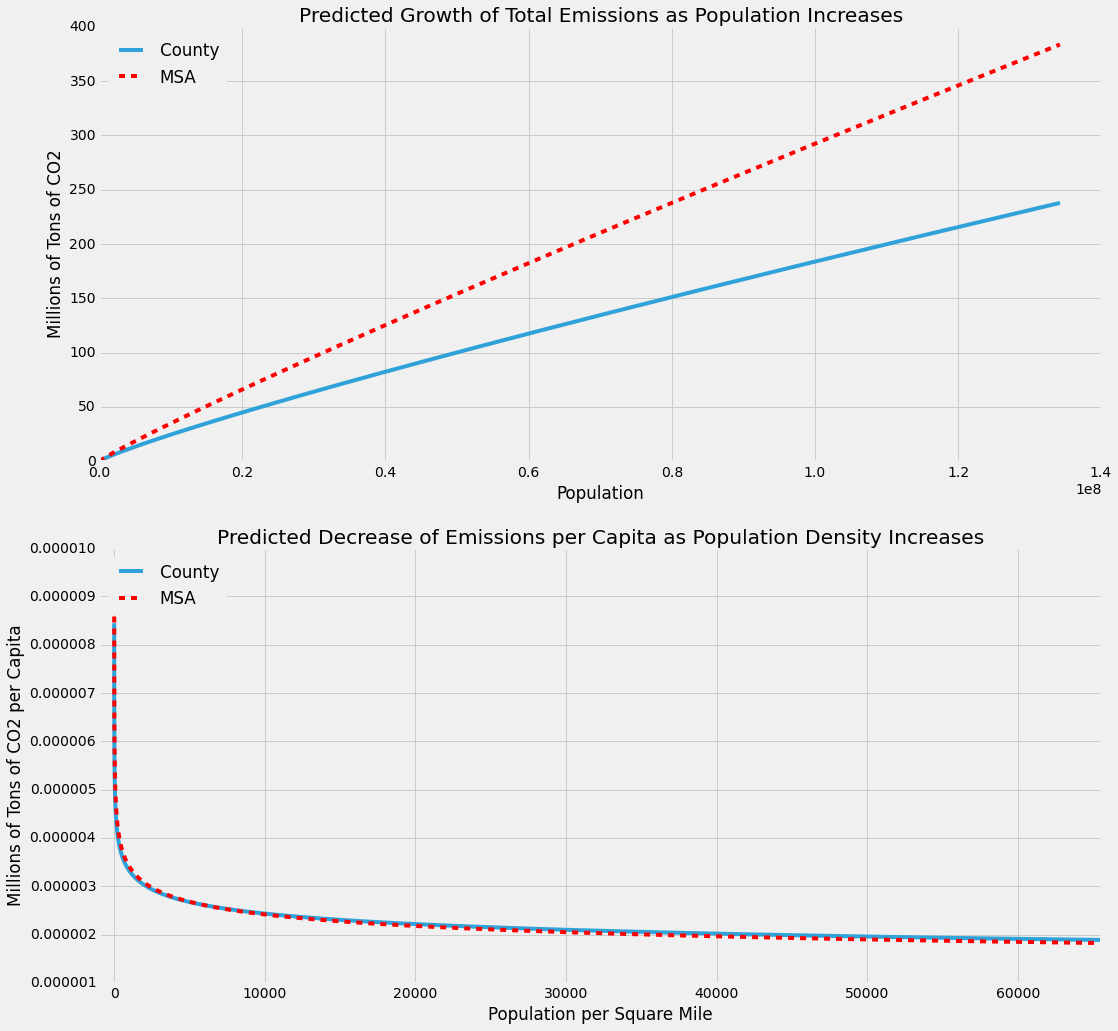

In [487]:
fig, ((ax1, ax2)) = plt.subplots(figsize=(16,16), nrows=2, ncols=1)

# Pop vs Total
x = np.logspace(5,27,100,base=2)

y = 2**((np.log2(x)*.8755) + (-15.7450))
ax1.plot(x,y, label='County')

y = 2**((np.log2(x)*.9238) + (-16.3591))
ax1.plot(x,y, 'r--', label='MSA')

ax1.set_title('Predicted Growth of Total Emissions as Population Increases')
ax1.set_ylabel('Millions of Tons of CO2')
ax1.set_xlabel('Population')
ax1.legend(loc='upper left')

x = np.logspace(0,16,100,base=2)

y = 2**((np.log2(x)*-.1351) + (-16.8534))
ax2.plot(x,y, label='County')

y = 2**((np.log2(x)*-0.1496) + (-16.6717))
ax2.plot(x,y, 'r--',label='MSA')

ax2.set_title('Predicted Decrease of Emissions per Capita as Population Density Increases')
ax2.set_ylabel('Millions of Tons of CO2 per Capita')
ax2.set_xlabel('Population per Square Mile')
ax2.legend(loc='upper left')
ax2.set_xlim([-1000,2**16])

In [425]:
np.logspace(0,20,100,base=2)

array([  1.00000000e+00,   1.15030800e+00,   1.32320850e+00,
         1.52209732e+00,   1.75088073e+00,   2.01405211e+00,
         2.31678026e+00,   2.66501086e+00,   3.06558332e+00,
         3.52636502e+00,   4.05640590e+00,   4.66611616e+00,
         5.36747075e+00,   6.17424455e+00,   7.10228290e+00,
         8.16981285e+00,   9.39780109e+00,   1.08103658e+01,
         1.24352503e+01,   1.43043679e+01,   1.64544288e+01,
         1.89276611e+01,   2.17726400e+01,   2.50452420e+01,
         2.88097423e+01,   3.31400770e+01,   3.81212958e+01,
         4.38512315e+01,   5.04424225e+01,   5.80243221e+01,
         6.67458420e+01,   7.67782761e+01,   8.83186653e+01,
         1.01593667e+02,   1.16864008e+02,   1.34429604e+02,
         1.54635449e+02,   1.77878394e+02,   2.04614940e+02,
         2.35370203e+02,   2.70748227e+02,   3.11443852e+02,
         3.58256355e+02,   4.12105151e+02,   4.74047853e+02,
         5.45301038e+02,   6.27264147e+02,   7.21546967e+02,
         8.30001249e+02,

In [423]:
np.log2(1000000)

19.931568569324174

In [429]:
np.log2(x)*-.1351

array([-1.0808    , -1.09717576, -1.11355152, -1.12992727, -1.14630303,
       -1.16267879, -1.17905455, -1.1954303 , -1.21180606, -1.22818182,
       -1.24455758, -1.26093333, -1.27730909, -1.29368485, -1.31006061,
       -1.32643636, -1.34281212, -1.35918788, -1.37556364, -1.39193939,
       -1.40831515, -1.42469091, -1.44106667, -1.45744242, -1.47381818,
       -1.49019394, -1.5065697 , -1.52294545, -1.53932121, -1.55569697,
       -1.57207273, -1.58844848, -1.60482424, -1.6212    , -1.63757576,
       -1.65395152, -1.67032727, -1.68670303, -1.70307879, -1.71945455,
       -1.7358303 , -1.75220606, -1.76858182, -1.78495758, -1.80133333,
       -1.81770909, -1.83408485, -1.85046061, -1.86683636, -1.88321212,
       -1.89958788, -1.91596364, -1.93233939, -1.94871515, -1.96509091,
       -1.98146667, -1.99784242, -2.01421818, -2.03059394, -2.0469697 ,
       -2.06334545, -2.07972121, -2.09609697, -2.11247273, -2.12884848,
       -2.14522424, -2.1616    , -2.17797576, -2.19435152, -2.21

In [432]:
merged.describe()

,STCOU,Population,area,FIPS,Total,Commercial,Industrial,Residential,Electricity Prod,Onroad,Cement,Aircraft,Airborne,Nonroad,CO2PerSquareMile,CO2PerCapita,PopulationDensity,ResCO2PerCapita
count,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3137.000000,3.137000e+03,3137.000000,3.137000e+03
mean,30442.475932,91726.481352,1120.909525,30442.475932,0.510211,0.021182,0.091085,0.032434,0.197305,0.127426,0.004019,0.005840,0.015276,0.015645,0.001130,1.117179e-05,246.803324,9.081878e-06
std,15132.060995,299360.141171,3619.971300,15132.060995,1.199206,0.077782,0.437127,0.108508,0.687778,0.325797,0.032669,0.025514,0.065622,0.034945,0.004554,3.685907e-05,1692.453933,3.671871e-05
min,1001.000000,66.000000,1.990000,1001.000000,0.001961,0.000000,0.000000,0.000000,0.000000,0.000088,0.000000,0.000000,0.000000,0.000004,0.000001,9.630607e-07,0.043674,1.800141e-07
25%,19003.000000,11168.000000,431.710000,19003.000000,0.047462,0.001067,0.003497,0.003408,0.000000,0.021901,0.000000,0.000000,0.000000,0.003920,0.000072,2.993810e-06,16.956660,1.242196e-06
50%,29183.000000,24904.000000,615.850000,29183.000000,0.116034,0.003260,0.014864,0.007764,0.000000,0.048463,0.000000,0.000957,0.002412,0.007763,0.000182,4.010439e-06,42.955963,1.971957e-06
75%,45085.000000,62337.000000,922.900000,45085.000000,0.342376,0.011566,0.048559,0.020560,0.001947,0.109031,0.000000,0.003723,0.009378,0.013888,0.000571,6.333830e-06,106.266794,3.867465e-06
max,56045.000000,9717871.000000,145899.690000,56045.000000,21.316004,1.717594,9.890448,3.251092,7.406676,9.360510,0.849118,0.979744,2.462769,0.867329,0.173763,8.007267e-04,68259.625436,7.984987e-04


In [433]:
2**(np.log2(x)*-.1351)

array([ 1.59715021,  1.5672193 ,  1.53784931,  1.50902971,  1.4807502 ,
        1.45300066,  1.42577114,  1.39905191,  1.37283341,  1.34710624,
        1.32186121,  1.29708927,  1.27278157,  1.24892939,  1.22552421,
        1.20255765,  1.18002149,  1.15790766,  1.13620824,  1.11491548,
        1.09402175,  1.07351957,  1.0534016 ,  1.03366065,  1.01428965,
        0.99528166,  0.97662989,  0.95832766,  0.94036841,  0.92274572,
        0.90545329,  0.88848492,  0.87183454,  0.85549619,  0.83946402,
        0.82373231,  0.8082954 ,  0.79314779,  0.77828404,  0.76369885,
        0.74938699,  0.73534333,  0.72156285,  0.70804062,  0.6947718 ,
        0.68175165,  0.66897549,  0.65643876,  0.64413697,  0.63206571,
        0.62022068,  0.60859762,  0.59719239,  0.58600088,  0.57501911,
        0.56424314,  0.55366912,  0.54329325,  0.53311183,  0.52312121,
        0.51331782,  0.50369814,  0.49425874,  0.48499624,  0.47590731,
        0.46698872,  0.45823726,  0.4496498 ,  0.44122328,  0.43

In [436]:
np.log2(x)*-.1351

array([ 0.6755    ,  0.64820707,  0.62091414,  0.59362121,  0.56632828,
        0.53903535,  0.51174242,  0.48444949,  0.45715657,  0.42986364,
        0.40257071,  0.37527778,  0.34798485,  0.32069192,  0.29339899,
        0.26610606,  0.23881313,  0.2115202 ,  0.18422727,  0.15693434,
        0.12964141,  0.10234848,  0.07505556,  0.04776263,  0.0204697 ,
       -0.00682323, -0.03411616, -0.06140909, -0.08870202, -0.11599495,
       -0.14328788, -0.17058081, -0.19787374, -0.22516667, -0.2524596 ,
       -0.27975253, -0.30704545, -0.33433838, -0.36163131, -0.38892424,
       -0.41621717, -0.4435101 , -0.47080303, -0.49809596, -0.52538889,
       -0.55268182, -0.57997475, -0.60726768, -0.63456061, -0.66185354,
       -0.68914646, -0.71643939, -0.74373232, -0.77102525, -0.79831818,
       -0.82561111, -0.85290404, -0.88019697, -0.9074899 , -0.93478283,
       -0.96207576, -0.98936869, -1.01666162, -1.04395455, -1.07124747,
       -1.0985404 , -1.12583333, -1.15312626, -1.18041919, -1.20